In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from collections import namedtuple
from numpy.random import default_rng
from scipy.stats import poisson
rng = default_rng()

In [60]:
class GamblerEnv():
    def __init__(self, p_coin):
        self.p_coin = p_coin
        self.transition_table = {}
        self.terminal_states = set([0, 100])
        
    def p(self, s, a):
        if s in self.terminal_states:
            return [(s, 0, 1.0)]
        
        # winning gets 1 otherwise reward will be 0
        return [(min(100, s + a), 0, self.p_coin), 
                (max(0, s - a), 0, 1-self.p_coin)] 
        

In [117]:
def plot_v(v):
    plt.plot(v)

def value_itr(p_coin):
    env = GamblerEnv(p_coin)
    v = np.zeros((101,))
    v[100] = 1
    pi = np.zeros((101,))
    tolerance = 1e-6
    itr = 0
    plt.figure(1)
    while True:
        delta = 0
        for s in range(1, 100):
            old_v = v[s]
            new_max_v = - np.Inf
            argm = None
            for a in range(1, min(s, 100 - s) + 1):
                cur_v = 0
                for (sp, r, prob) in env.p(s , a):
                    cur_v += (prob * (r + v[sp]))
                if cur_v > new_max_v:
                    new_max_v = cur_v
                    argm = a
            pi[s] = argm
            v[s] = new_max_v
            delta = max(delta, np.absolute(old_v - new_max_v))
                
        if delta < tolerance:
            break
        
        itr += 1
        if itr < 5:
            plot_v(v)
        
        
    plot_v(v)
    return (v, pi)
    

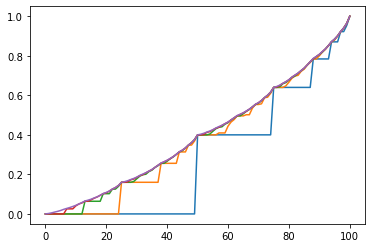

In [119]:
v04, pi04 = value_itr(0.4)

<BarContainer object of 101 artists>

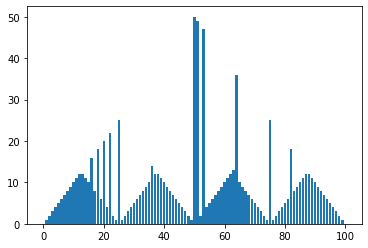

In [120]:
plt.bar(range(len(pi04)), pi04)

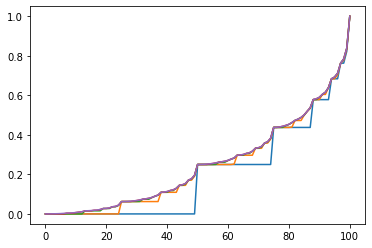

In [121]:
v025, pi025 = value_itr(0.25)

<BarContainer object of 101 artists>

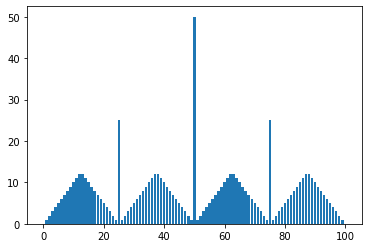

In [122]:
plt.bar(range(len(pi025)), pi025)

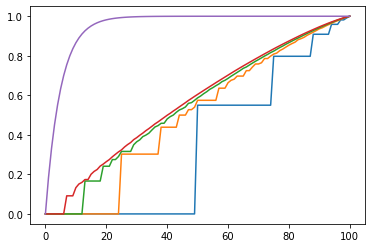

In [123]:
v055, pi055 = value_itr(0.55)

<BarContainer object of 101 artists>

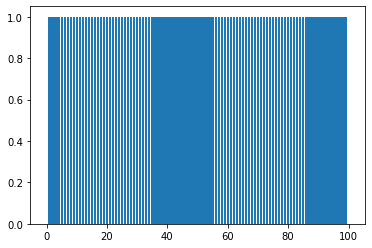

In [124]:
plt.bar(range(len(pi055)), pi055)

In [111]:
def find_pi(v, env):
    pi = np.zeros((100,))
    for s in range(1, 100):
        argm = []
        max_v = -np.Inf
        for a in range(1, min(s, 100 - s) + 1):
            cur_v = 0
            for (sp, r, prob) in env.p(s, a):
                cur_v += prob * (r + v[sp])
            
            if cur_v > max_v:
                max_v = cur_v
                argm = [a]
            elif cur_v == max_v:
                argm.append(a)
                
        pi[s] = argm[0] #np.random.choice(argm)
    return pi

def find_and_plot_pi(v, p_coin):
    pi = find_pi(v, GamblerEnv(p_coin))
    plt.bar(range(len(pi)), pi)
    return pi

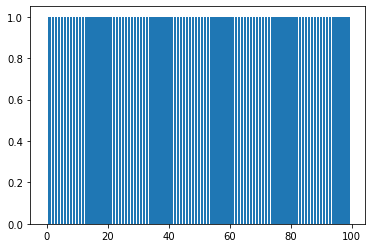

In [125]:
pi055_p = find_and_plot_pi(v055, 0.55)

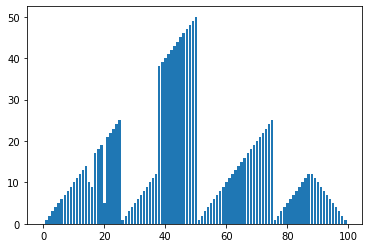

In [126]:
pi025_p = find_and_plot_pi(v025, 0.25)

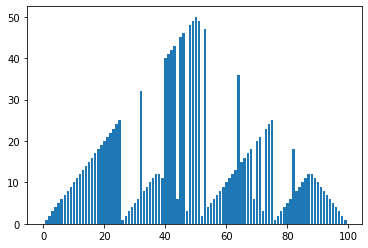

In [127]:
pi04_p = find_and_plot_pi(v04, 0.4)

We can check if they belong to the same family by running simulation

In [139]:
def coin_toss_sim(rate, policy):
    win = np.zeros((100,))
    loss = np.zeros((100,))
    for _ in range(3000):
        game_ended = False
        s = np.random.randint(1, 100)
        starting_s = s
        while not game_ended:
            bet = policy[int(s)]
            is_head = np.random.random() < rate
            if is_head:
                s += bet
            else:
                s -= bet
            
            if s >= 100:
                game_ended = True
                win[starting_s] += 1
            elif s <= 0:
                game_ended = True
                loss[starting_s] += 1
    return (win, loss)
            
                

In [146]:
def bar(pi):
    plt.bar(range(len(pi)), pi, alpha=0.7)

In [140]:
(win025_p, loss025_p) = coin_toss_sim(0.25, pi025_p)

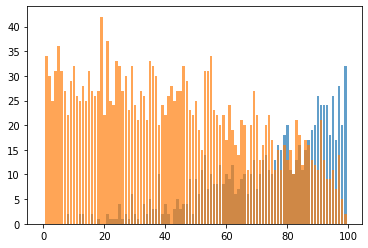

In [147]:
bar(win025_p)
bar(loss025_p)

In [148]:
(win025, loss025) = coin_toss_sim(0.25, pi025)

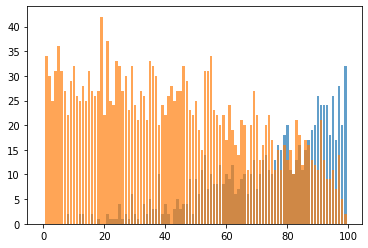

In [149]:
bar(win025_p)
bar(loss025_p)

In [150]:
(win_check055, loss_check055) = coin_toss_sim(0.25, pi055)

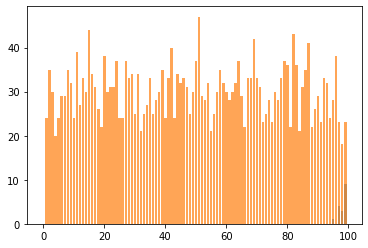

In [151]:
bar(win_check055)
bar(loss_check055)

In [152]:
(win055, loss055) = coin_toss_sim(0.55, pi055)

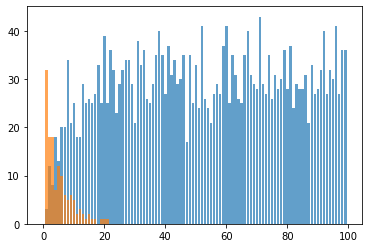

In [153]:
bar(win055)
bar(loss055)

As we can see, running two different policy from the optimal policy family of 25% head games give the same distribution. And running a 55% head games optimal policy against 25% head games is too aggressive and it blows up in loss rate. Running 55% head games optimal policy against 55% game yield excellent performance.